In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os, time
from scipy.optimize import linear_sum_assignment


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def voc_transform(image, target):
    anno = target['annotation']
    objs = anno.get('object')
    if not isinstance(objs, list):
        objs = [objs]
    boxes = []
    labels = []
    im_width = float(anno['size']['width'])
    im_height = float(anno['size']['height'])
    voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
                   'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
                   'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    for obj in objs:
        bbox = obj['bndbox']
        xmin = float(bbox['xmin']) / im_width
        ymin = float(bbox['ymin']) / im_height
        xmax = float(bbox['xmax']) / im_width
        ymax = float(bbox['ymax']) / im_height
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(voc_classes.index(obj['name']))
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)
    target_processed = {'boxes': boxes, 'labels': labels}
    return image, target_processed

class VOCDataset(Dataset):
    def __init__(self, voc_dataset, transform=None):
        self.voc_dataset = voc_dataset
        self.transform = transform

    def __len__(self):
        return len(self.voc_dataset)

    def __getitem__(self, idx):
        image, target = self.voc_dataset[idx]
        if self.transform:
            image = self.transform(image)
        image, target = voc_transform(image, target)
        return image, target

data_dir = './VOCdevkit'
os.makedirs(data_dir, exist_ok=True)
train_voc = torchvision.datasets.VOCDetection(root=data_dir, year='2012', image_set='train', download=True)
val_voc   = torchvision.datasets.VOCDetection(root=data_dir, year='2012', image_set='val', download=True)


100%|██████████| 2.00G/2.00G [01:25<00:00, 23.4MB/s]


In [ ]:
train_transform = T.Compose([
    T.Resize((512, 512)),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor()
])
val_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])


train_data = VOCDataset(train_voc, transform=train_transform)
val_data   = VOCDataset(val_voc, transform=val_transform)

def collate_fn(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images, dim=0)
    return images, targets

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_data, batch_size=4, shuffle=False, collate_fn=collate_fn)


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_h=50, max_w=50):
        super(PositionalEncoding, self).__init__()
        self.row_embed = nn.Embedding(max_h, d_model // 2)
        self.col_embed = nn.Embedding(max_w, d_model // 2)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, x):
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)
        x_emb = self.col_embed(i)
        y_emb = self.row_embed(j)
        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1)
        pos = pos.permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
        return pos

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(MLP, self).__init__()
        layers = []
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim
            out_dim = output_dim if i == num_layers - 1 else hidden_dim
            layers.append(nn.Linear(in_dim, out_dim))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < len(self.layers)-1 else layer(x)
        return x

class DETRResNet(nn.Module):
    def __init__(self, num_classes, num_queries=100, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super(DETRResNet, self).__init__()
        self.num_queries = num_queries

        resnet = torchvision.models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])
        self.input_proj = nn.Conv2d(2048, hidden_dim, kernel_size=1)

        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=nheads,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers)

        self.pos_encoding = PositionalEncoding(hidden_dim)
        self.query_pos = nn.Parameter(torch.rand(num_queries, hidden_dim))
        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)

    def forward(self, x):
        bs = x.shape[0]
        feat = self.backbone(x)
        proj_feat = self.input_proj(feat)
        h, w = proj_feat.shape[-2:]
        proj_feat_flat = proj_feat.flatten(2).permute(2, 0, 1)
        pos = self.pos_encoding(feat)
        pos_flat = pos.flatten(2).permute(2, 0, 1)
        query_pos = self.query_pos.unsqueeze(1).repeat(1, bs, 1)
        tgt = torch.zeros_like(query_pos) + query_pos
        memory = self.transformer.encoder(proj_feat_flat + pos_flat)
        hs = self.transformer.decoder(tgt, memory)

        hs = hs.transpose(0, 1)
        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()

        return {'pred_logits': outputs_class, 'pred_boxes': outputs_coord}

if __name__ == '__main__':
    dummy = torch.randn(2, 3, 512, 512)
    model = DETRResNet(num_classes=20)
    out = model(dummy)
    print(out['pred_logits'].shape, out['pred_boxes'].shape)


torch.Size([2, 100, 21]) torch.Size([2, 100, 4])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(MLP, self).__init__()
        layers = []
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim
            out_dim = output_dim if i == num_layers - 1 else hidden_dim
            layers.append(nn.Linear(in_dim, out_dim))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < len(self.layers) - 1 else layer(x)
        return x

class DETRViT(nn.Module):
    def __init__(self, num_classes, num_queries=100, hidden_dim=768, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6, input_size=224):
        super(DETRViT, self).__init__()
        self.num_queries = num_queries
        self.input_size = input_size
        vit = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1)
        self.backbone = vit
        self.backbone.heads = nn.Identity()

        if hasattr(self.backbone, 'cls_token'):
            self.cls_token = self.backbone.cls_token
        else:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        patch_size = self.backbone.patch_size
        num_patches = (self.input_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.rand(num_patches, hidden_dim))

        self.transformer = nn.Transformer(d_model=hidden_dim, nhead=nheads,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers)

        self.query_pos = nn.Parameter(torch.rand(num_queries, hidden_dim))

        self.class_embed = nn.Linear(hidden_dim, num_classes + 1)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)

    def forward_features(self, x):
        B = x.shape[0]
        x = F.interpolate(x, size=(self.input_size, self.input_size), mode='bilinear', align_corners=False)
        x = self.backbone.conv_proj(x)
        x = x.flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.backbone.encoder(x)
        if hasattr(self.backbone, 'norm'):
            x = self.backbone.norm(x)
        return x

    def forward(self, x):
        B = x.shape[0]
        features = self.forward_features(x)
        if features.dim() == 3 and features.size(1) > 1:
            patch_tokens = features[:, 1:, :]
        else:
            raise IndexError(f"Expected features shape (B, 1+num_patches, hidden_dim), got {features.shape}")

        patch_tokens = patch_tokens + self.pos_embed.unsqueeze(0)
        patch_tokens = patch_tokens.permute(1, 0, 2)
        memory = self.transformer.encoder(patch_tokens)
        query_pos = self.query_pos.unsqueeze(1).repeat(1, B, 1)
        tgt = query_pos.clone()
        hs = self.transformer.decoder(tgt, memory)
        hs = hs.transpose(0, 1)

        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        return {'pred_logits': outputs_class, 'pred_boxes': outputs_coord}

if __name__ == '__main__':
    dummy = torch.randn(2, 3, 512, 512)
    model_vit = DETRViT(num_classes=20)
    out = model_vit(dummy)
    print("pred_logits shape:", out['pred_logits'].shape)
    print("pred_boxes shape:", out['pred_boxes'].shape)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


pred_logits shape: torch.Size([2, 100, 21])
pred_boxes shape: torch.Size([2, 100, 4])


In [ ]:
!pip show transformers
!pip show torchvision

Name: transformers
Version: 4.50.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers
Name: torchvision
Version: 0.21.0+cu124
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, pillow, torch
Required-by: fastai, timm


In [ ]:
def matcher(pred_logits, pred_boxes, targets):
    indices = []
    for b in range(len(targets)):
        tgt = targets[b]
        tgt_boxes = tgt['boxes']
        tgt_labels = tgt['labels']
        num_obj = tgt_boxes.shape[0]
        out_prob = pred_logits[b].softmax(-1)
        cost_class = torch.zeros(pred_logits[b].shape[0], num_obj, device=pred_logits.device)
        for i in range(num_obj):
            cost_class[:, i] = -out_prob[:, tgt_labels[i]]
        cost_bbox = torch.cdist(pred_boxes[b], tgt_boxes, p=1)
        cost = cost_class + cost_bbox
        cost_np = cost.detach().cpu().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_np)
        indices.append((torch.as_tensor(row_ind, dtype=torch.int64),
                        torch.as_tensor(col_ind, dtype=torch.int64)))
    return indices

class DETRLoss(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict):
        super(DETRLoss, self).__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.cls_loss_fn = nn.CrossEntropyLoss()
        self.l1_loss_fn = nn.L1Loss()

    def forward(self, outputs, targets):
        pred_logits = outputs['pred_logits']
        pred_boxes = outputs['pred_boxes']
        batch_size, num_queries, _ = pred_logits.shape

        target_classes = torch.full((batch_size, num_queries), self.num_classes,
                                     dtype=torch.int64, device=pred_logits.device)
        target_boxes = torch.zeros((batch_size, num_queries, 4),
                                   dtype=torch.float32, device=pred_boxes.device)

        indices = self.matcher(pred_logits, pred_boxes, targets)
        for b, (pred_idx, tgt_idx) in enumerate(indices):
            tgt = targets[b]
            target_classes[b, pred_idx] = tgt['labels'][tgt_idx]
            target_boxes[b, pred_idx] = tgt['boxes'][tgt_idx]

        loss_cls = self.cls_loss_fn(pred_logits.flatten(0,1), target_classes.flatten(0,1))
        mask = (target_classes != self.num_classes)
        if mask.sum() > 0:
            loss_bbox = self.l1_loss_fn(pred_boxes[mask], target_boxes[mask])
        else:
            loss_bbox = torch.tensor(0.0, device=pred_boxes.device)

        total_loss = self.weight_dict['loss_cls'] * loss_cls + self.weight_dict['loss_bbox'] * loss_bbox
        return total_loss, {'loss_cls': loss_cls.item(), 'loss_bbox': loss_bbox.item()}


In [ ]:
from tqdm.notebook import tqdm

def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2Area = (box2[2]-box2[0])*(box2[3]-box2[1])
    return interArea / float(box1Area + box2Area - interArea + 1e-6)


def train_one_epoch(model, criterion, data_loader, optimizer, device):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for images, targets in progress_bar:
        images = images.to(device)
        for t in targets:
            t['boxes'] = t['boxes'].to(device)
            t['labels'] = t['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss, loss_dict = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': loss.item()})
    return running_loss / len(data_loader)

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_gts = []
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating", leave=False):
            images = images.to(device)
            outputs = model(images)
            pred_logits = outputs['pred_logits']
            pred_boxes = outputs['pred_boxes']
            pred_scores = pred_logits.softmax(-1)
            scores, labels = pred_scores.max(-1)
            for i in range(images.size(0)):
                keep = scores[i] > 0.7
                boxes = pred_boxes[i][keep].cpu().numpy()
                cls = labels[i][keep].cpu().numpy()
                scr = scores[i][keep].cpu().numpy()
                all_preds.append({'boxes': boxes, 'labels': cls, 'scores': scr})
                gt = targets[i]
                all_gts.append({'boxes': gt['boxes'].cpu().numpy(), 'labels': gt['labels'].cpu().numpy()})

    precisions, recalls, f1s, aps50, aps75 = [], [], [], [], []
    for preds, gts in zip(all_preds, all_gts):
        pred_boxes = preds['boxes']
        pred_labels = preds['labels']
        gt_boxes = gts['boxes']
        gt_labels = gts['labels']
        tp = 0
        fp = 0
        matched = []
        for i, pb in enumerate(pred_boxes):
            ious = [compute_iou(pb, gb) for gb in gt_boxes] if len(gt_boxes) > 0 else []
            if len(ious) == 0:
                fp += 1
                continue
            max_iou = max(ious)
            max_idx = np.argmax(ious)
            if max_iou >= 0.5 and pred_labels[i] == gt_labels[max_idx] and max_idx not in matched:
                tp += 1
                matched.append(max_idx)
            else:
                fp += 1
        fn = len(gt_boxes) - len(matched)
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        aps50.append(1.0 if precision > 0.5 else 0.0)
        aps75.append(1.0 if precision > 0.75 else 0.0)

    metrics = {
        'mAP': np.mean(precisions),
        'AP50': np.mean(aps50),
        'AP75': np.mean(aps75),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls),
        'F1 Score': np.mean(f1s)
    }
    return metrics


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 20
model_resnet = DETRResNet(num_classes=num_classes, num_queries=100).to(device)
model_vit = DETRViT(num_classes=num_classes, num_queries=100).to(device)
weight_dict = {'loss_cls': 1.0, 'loss_bbox': 5.0}
criterion_resnet = DETRLoss(num_classes=num_classes, matcher=matcher, weight_dict=weight_dict)
criterion_vit = DETRLoss(num_classes=num_classes, matcher=matcher, weight_dict=weight_dict)

optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)
optimizer_vit = torch.optim.Adam(model_vit.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
print(device)

cuda


In [ ]:
from tqdm.notebook import tqdm
num_epochs = 3
loss_history_resnet = []
loss_history_vit = []

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    loss_resnet = train_one_epoch(model_resnet, criterion_resnet, train_loader, optimizer_resnet, device)
    loss_vit = train_one_epoch(model_vit, criterion_vit, train_loader, optimizer_vit, device)
    loss_history_resnet.append(loss_resnet)
    loss_history_vit.append(loss_vit)
    print(f"ResNet DETR Loss: {loss_resnet:.4f}")
    print(f"ViT DETR Loss: {loss_vit:.4f}")


Training Epochs:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1/3


Training:   0%|          | 0/1430 [00:00<?, ?it/s]

Training:   0%|          | 0/1430 [00:00<?, ?it/s]

ResNet DETR Loss: 0.6201
ViT DETR Loss: 0.6700

Epoch 2/3


Training:   0%|          | 0/1430 [00:00<?, ?it/s]

Training:   0%|          | 0/1430 [00:00<?, ?it/s]

ResNet DETR Loss: 0.5283
ViT DETR Loss: 0.5401

Epoch 3/3


Training:   0%|          | 0/1430 [00:00<?, ?it/s]

Training:   0%|          | 0/1430 [00:00<?, ?it/s]

ResNet DETR Loss: 0.5171
ViT DETR Loss: 0.5258


In [ ]:
metrics_resnet = evaluate_model(model_resnet, val_loader, device)
metrics_vit = evaluate_model(model_vit, val_loader, device)
print("ResNet DETR Evaluation Metrics:")
print(metrics_resnet)
print("\nViT DETR Evaluation Metrics:")
print(metrics_vit)


Evaluating:   0%|          | 0/1456 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1456 [00:00<?, ?it/s]

ResNet DETR Evaluation Metrics:
{'mAP': np.float64(0.0), 'AP50': np.float64(0.0), 'AP75': np.float64(0.0), 'Precision': np.float64(0.0), 'Recall': np.float64(0.0), 'F1 Score': np.float64(0.0)}

ViT DETR Evaluation Metrics:
{'mAP': np.float64(0.0), 'AP50': np.float64(0.0), 'AP75': np.float64(0.0), 'Precision': np.float64(0.0), 'Recall': np.float64(0.0), 'F1 Score': np.float64(0.0)}


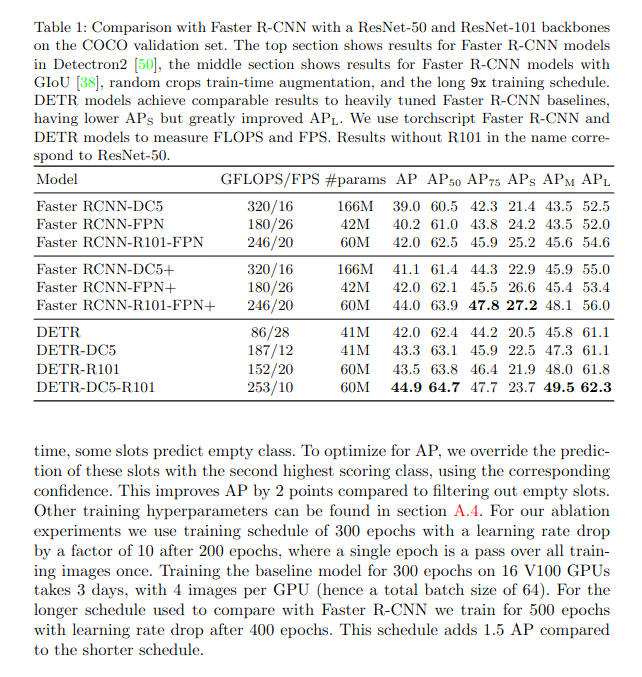

In [ ]:
### we can see the discussion here in the detr paper(https://arxiv.org/pdf/2005.12872)... so it is clear that they need very long sequence of training like 300-500 epochs to get trained and give meaningful results.. in our environment it is not possible to train for 300 epochs or 500 epochs..

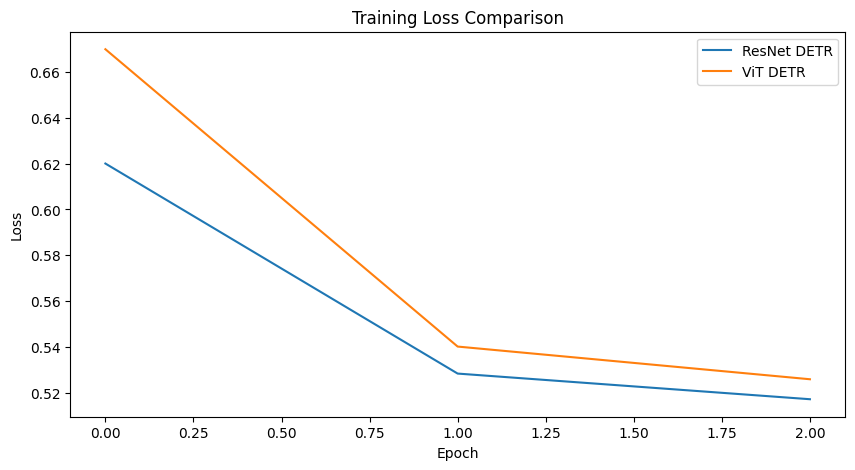

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(loss_history_resnet, label="ResNet DETR")
plt.plot(loss_history_vit, label="ViT DETR")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()
